# The diff from sympy to calculate the capillarity gives an overcomplicated expression. - Also with a different result :S

In [68]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.optimize import curve_fit
import sympy as sympy
from IPython.display import display

In [69]:
@dataclass
class soilDict:
    K_s     : float
    theta_s : float
    theta_r : float
    alpha   : float
    nExpon  : float
    mExpon  : float = 0
    
    def __post_init__(self):
        self.mExpon = 1.0 - (1.0/self.nExpon)


In [70]:
a,x,y,n = sympy.symbols("a x y n")
y = (a*x)**n
display(y)

dy = sympy.diff(y,x).expand().simplify()
display(dy)

(a*x)**n

n*(a*x)**n/x

In [75]:
θ,θs,θr,α,h,n,m = sympy.symbols("θ θs θr α h n m")
θe = (1 + (-α*h)**n)**-m
display(θe)

((-h*α)**n + 1)**(-m)

In [78]:
# Capillary capacity
dθe = sympy.diff(θe, h).simplify() * (θs - θr)
display(dθe)

-m*n*(-h*α)**n*(-θr + θs)*((-h*α)**n + 1)**(-m - 1)/h

In [79]:
soil = soilDict(2.89E-6,0.43,0.078,3.6,1.56)

def thetaEffectiveCalc(h,soil): 
    se = np.where(
            h >= 0,
            1.0,
            np.power(1.0 + np.power(- soil.alpha * h, soil.nExpon), - soil.mExpon)
            )
    return se

def refactorthetaEffectiveCalc(h,soil): 
    se = np.power(1.0 + np.power(np.maximum(-soil.alpha * h, 0), soil.nExpon), - soil.mExpon)
    return se

def thetaCalc(h,soil:soilDict):
    theta = thetaEffectiveCalc(h,soil) * (soil.theta_s - soil.theta_r) + soil.theta_r   
    return theta
    
def capillaryCalc(h,soil:soilDict):
    capillary = np.where(
                    h >= 0, 
                    0.0,
                    (soil.theta_s - soil.theta_r) * soil.mExpon * soil.nExpon * soil.alpha * np.power(-soil.alpha * h, soil.nExpon - 1.0) * np.power(1.0 + np.power(-soil.alpha * h, soil.nExpon), - soil.mExpon - 1.0)
                    )
    return capillary

def hydraulicCondCalc(h,soil):
    se = thetaEffectiveCalc(h,soil)
    kr = np.sqrt(se) * np.power(1 - np.power(1 - np.power(se, 1/soil.mExpon),soil.mExpon),2)
    return kr

In [80]:
hLin = np.linspace(-5,2,200)
thetaLin = thetaEffectiveCalc(hLin,soil=soil)
thetaLin2 = refactorthetaEffectiveCalc(hLin,soil=soil)

/tmp/ipykernel_142899/1394261343.py:7: RuntimeWarning: invalid value encountered in power
  np.power(1.0 + np.power(- soil.alpha * h, soil.nExpon), - soil.mExpon)


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


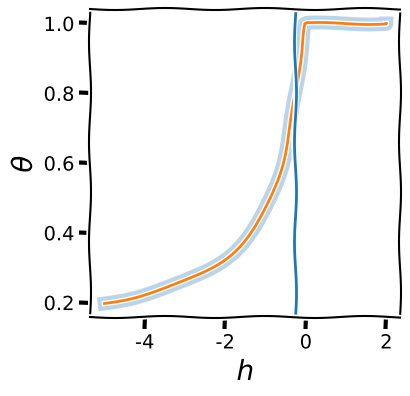

In [81]:
with plt.xkcd(randomness=1):
    fig,axs = plt.subplots(1,1,figsize=[4,4])
    ax = axs
    ax.plot(hLin,thetaLin,lw=10,alpha=0.3)
    ax.plot(hLin,thetaLin2)
    ax.axvline(x=-1/soil.alpha)
    #ax.axhline(y=soil.theta_r)
    ax.set_ylabel(r'$\theta$',fontsize=20)
    ax.set_xlabel(r'$h$',fontsize=20)

    # ax = axs[1]
    # ax.plot(hLin,capiLin)

    # ax = axs[2]
    # ax.plot(hLin,permLin)
    plt.show()